In [4]:
import os
import pandas as pd
import sys
import os
from subprocess import call

#%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
sys.path.append("../../")

from common_v2.validation_tools import regr_datasets, subsets, metrics, reps, transfer_datasets, pearson
import common_v2.validation_tools
from IPython.display import display, HTML
import numpy as np

import random
from scipy.stats import ttest_1samp
from sklearn.externals import joblib
from matplotlib.lines import Line2D

import common_v2.plot_style_utils as plot_style_utils
from common_v2.plot_style_utils import task_names

random.seed(42)
np.random.seed(42)

In [5]:
run_type = 'test' # change to 'validate' and rerun the notebook if interested in the validation set scores

## Data import and helpful functions putting the data in a nicer format

In [6]:
#path_to_pieces = f"../data/pieces_new/"
data_path = "../../../data/"

stds = pd.read_csv(f"{data_path}std_results_val_resamp.csv", index_col=0)

regr_datasets.loc[9] = 'rocklin_ssm2_nat_eng'

def get_tab_dict(metric, to_plot=False):
    
    fig_n=1

    tab_dict = {}

    for d in regr_datasets:
        ss = subsets[d]
        if (len(ss) > 1) & (d != 'rocklin_ssm2_nat_eng'):
            ss = list(ss)+["full"]
        for s in ss:
            rep_dict = {}
            std_dict = {}
            for rep in reps:
                try:
                    rep_dict[rep] = pd.read_csv(
                        f"{data_path}results/{d}__{s}__{rep}__{run_type}__regression_results.csv", header=None, index_col=0
                    ).loc[metric].iloc[0]
                    std_dict[rep] = stds.loc[f"{d}__{s}__{rep}__{run_type}"][metric]
                except Exception as e:
                    print(e)
            try:
                ser = pd.Series(rep_dict).sort_values(ascending=False)
                tab = pd.concat([ser, pd.Series(std_dict).loc[ser.index]], axis=1)
                tab.columns = ['avg','stdev']
                if to_plot:
                    
                    tab_to_plot = tab.copy()
                    
                    tab_to_plot.index = [plot_style_utils.rep_names[n] for n in tab_to_plot.index]
                    
                tab_dict[(d,s)] = tab
            except Exception as e:
                print(e)
    return tab_dict

all_df = pd.Series(get_tab_dict('mse'))
ascending = True
#our_rep = 'all_1900'

d = 'arnold_T50'
s = 'T50'

final_rep_rough_names = ['all_1900','best_other_rep', 'RGN', 'best_arnold_rep', ]

def get_pub_reps_only(single_subset_df, by='avg'):

    best_arnold_name = single_subset_df.loc[[
        "arnold_original_3_7", 
        "arnold_scrambled_3_5", 
        "arnold_random_3_7", 
        "arnold_uniform_4_1"
    ]].sort_values(by=by,ascending=ascending).iloc[0].name

    best_other_name = single_subset_df.loc[[
        "simple_freq_plus","simple_freq_and_len",
        "tfidf_3grams", "3grams", "tfidf_2grams", "2grams"
    ]].sort_values(by=by,ascending=ascending).iloc[0].name
    
    to_return = single_subset_df.loc[['all_1900',best_other_name,'RGN', best_arnold_name]] #.sort_values(by='avg',ascending=ascending)

    to_return.index = final_rep_rough_names
    
    return to_return

In [7]:
all_df_pub_reps = all_df.copy().map(get_pub_reps_only)

## Fig 3b: statistical significance for comparisons against baselines for individual  proteins

In [8]:
all_df_for_rocklin_fig = pd.Series(get_tab_dict('pearson_r'))

d = 'rocklin_ssm2'
s = 'villin_ssm2_stability'

ascending=True

In [9]:
from scipy.stats import ttest_ind_from_stats


size = 10000

b_reps = [
         "mean",
        "simple_freq_plus","simple_freq_and_len",
        "tfidf_3grams", "3grams", "tfidf_2grams", "2grams"] # "RGN", "arnold_original_3_7", "arnold_scrambled_3_5", "arnold_random_3_7", "arnold_uniform_4_1",

for s in subsets[d]:
    print(d,s)
        
    pvalue = ttest_ind_from_stats(
        mean1 = all_df_for_rocklin_fig[d][s].loc[['all_1900']].sort_values(by='avg',ascending=ascending).avg.iloc[0],
        std1 = all_df_for_rocklin_fig[d][s].loc[['all_1900']].sort_values(by='avg',ascending=ascending).stdev.iloc[0],
        nobs1=30,
        mean2 = all_df_for_rocklin_fig[d][s].loc[b_reps].sort_values(by='avg',ascending=ascending).avg.iloc[0],
        std2 = all_df_for_rocklin_fig[d][s].loc[b_reps].sort_values(by='avg',ascending=ascending).stdev.iloc[0],
        nobs2=30,
        equal_var = False
    )
    print(pvalue[0],pvalue[1])
    print("\n")

rocklin_ssm2 EEHEE_rd3_0037.pdb_ssm2_stability
20.2792865234 5.42444832061e-21


rocklin_ssm2 EEHEE_rd3_1498.pdb_ssm2_stability
23.544320929 1.56642937208e-21


rocklin_ssm2 EEHEE_rd3_1702.pdb_ssm2_stability
2.91728963671 0.00553364746131


rocklin_ssm2 EEHEE_rd3_1716.pdb_ssm2_stability
27.861856155 5.15769371604e-26


rocklin_ssm2 EHEE_0882.pdb_ssm2_stability
21.5410351947 2.43924278545e-28


rocklin_ssm2 EHEE_rd2_0005.pdb_ssm2_stability
18.6773035965 6.5458719436e-25


rocklin_ssm2 EHEE_rd3_0015.pdb_ssm2_stability
17.4792083106 2.51711193878e-23


rocklin_ssm2 HEEH_rd2_0779.pdb_ssm2_stability
17.3464328045 2.00314229136e-20


rocklin_ssm2 HEEH_rd3_0223.pdb_ssm2_stability
20.0483560268 5.71236770973e-21


rocklin_ssm2 HEEH_rd3_0726.pdb_ssm2_stability
22.8965110246 1.32522745518e-24


rocklin_ssm2 HEEH_rd3_0872.pdb_ssm2_stability
25.2515939332 3.42068403622e-24


rocklin_ssm2 HHH_0142.pdb_ssm2_stability
15.2396129407 5.18705608928e-16


rocklin_ssm2 HHH_rd2_0134.pdb_ssm2_stability
17.2

In [10]:
for s in all_df_pub_reps['rocklin_ssm2'].index:
    if s != 'full':
       
        all_df_pub_reps.drop(('rocklin_ssm2', s), inplace=True)

for d in ['solubility', 'leuenberger']:
    all_df_pub_reps.drop(d, inplace=True)
    
all_df_pub_reps.drop(('fowler','full'), inplace=True)

/home/gr/miniconda3/envs/grig_alldatasets_run/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [11]:
final_table = pd.DataFrame(index=final_rep_rough_names, columns= all_df_pub_reps.index)

In [12]:
for d,s in final_table.columns:
    for rep in final_table.index:
        final_table.loc[rep, (d,s)] = all_df_pub_reps[d][s].loc[rep].avg

In [13]:
final_table_std = pd.DataFrame(index=final_rep_rough_names, columns= all_df_pub_reps.index)

for d,s in final_table_std.columns:
    for rep in final_table_std.index:
        final_table_std.loc[rep, (d,s)] = all_df_pub_reps[d][s].loc[rep].stdev

In [14]:
def highlight_min(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

def highlight_max(s):
    '''
    highlight the maximum in a Series green.
    '''
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

In [15]:
final_table.style.apply(highlight_min, axis=0).set_precision(3)

# Significance analysis for Supp. Tables S4-S5 and Fig3e

In [16]:
from scipy.stats import ttest_ind_from_stats

size = 10000

for d,s in final_table_std.columns[:4]:
    print(d,s)
    
    pvalue = ttest_ind_from_stats(
        mean1 = final_table[d][s][['all_1900',]].sort_values(ascending=ascending).iloc[0],
        std1 = final_table_std[d][s][['all_1900']].sort_values(ascending=ascending).iloc[0],
        nobs1=30,
        mean2 = final_table[d][s][['best_other_rep','best_arnold_rep', 'RGN']].sort_values(ascending=ascending).iloc[0],
        std2 = final_table_std[d][s][['best_other_rep','best_arnold_rep', 'RGN']].sort_values(ascending=ascending).iloc[0],
        nobs2=30,
        equal_var = False
    )
    print(pvalue)

arnold_T50 T50
Ttest_indResult(statistic=-1.763353543847048, pvalue=0.083255146358347132)
arnold_absorption peak
Ttest_indResult(statistic=-0.94989891318758479, pvalue=0.34625351177134811)
arnold_enantioselectivity e-value
Ttest_indResult(statistic=7.9312405929748042, pvalue=1.6239315823765277e-09)
arnold_localization log_GFP
Ttest_indResult(statistic=4.3883279074996544, pvalue=5.1563826122845527e-05)


In [17]:
from scipy.stats import ttest_ind_from_stats

size = 10000

for d,s in final_table_std.columns[:4]:
    print(d,s)
    
    pvalue = ttest_ind_from_stats(
        mean1 = final_table[d][s][['best_other_rep',]].sort_values(ascending=ascending).iloc[0],
        std1 = final_table_std[d][s][['best_other_rep']].sort_values(ascending=ascending).iloc[0],
        nobs1=30,
        mean2 = final_table[d][s][['all_1900','best_arnold_rep', 'RGN']].sort_values(ascending=ascending).iloc[0],
        std2 = final_table_std[d][s][['all_1900','best_arnold_rep', 'RGN']].sort_values(ascending=ascending).iloc[0],
        nobs2=30,
        equal_var = False
    )
    print(pvalue)

arnold_T50 T50
Ttest_indResult(statistic=4.3675268718598632, pvalue=5.5297243195609222e-05)
arnold_absorption peak
Ttest_indResult(statistic=1.8681482041807653, pvalue=0.067659811737845174)
arnold_enantioselectivity e-value
Ttest_indResult(statistic=-0.38496813169338073, pvalue=0.70169417563824488)
arnold_localization log_GFP
Ttest_indResult(statistic=-1.2364823491530763, pvalue=0.22139053238564932)


In [18]:
from scipy.stats import ttest_ind_from_stats

size = 10000

for d,s in final_table_std.columns[:4]:
    print(d,s)
    
    pvalue = ttest_ind_from_stats(
        mean1 = final_table[d][s][['best_other_rep',]].sort_values(ascending=ascending).iloc[0],
        std1 = final_table_std[d][s][['best_other_rep']].sort_values(ascending=ascending).iloc[0],
        nobs1=30,
        mean2 = final_table[d][s][['best_arnold_rep']].sort_values(ascending=ascending).iloc[0],
        std2 = final_table_std[d][s][['best_arnold_rep']].sort_values(ascending=ascending).iloc[0],
        nobs2=30,
        equal_var = False
    )
    print(pvalue)

arnold_T50 T50
Ttest_indResult(statistic=2.4591360929722881, pvalue=0.016936974406294904)
arnold_absorption peak
Ttest_indResult(statistic=0.98937580841243922, pvalue=0.32681960057634718)
arnold_enantioselectivity e-value
Ttest_indResult(statistic=-0.38496813169338073, pvalue=0.70169417563824488)
arnold_localization log_GFP
Ttest_indResult(statistic=-1.2364823491530763, pvalue=0.22139053238564932)


In [19]:
size = 10000

for d,s in final_table_std.columns[4:]:
    print(d,s)
    
    pvalue = ttest_ind_from_stats(
        mean1 = final_table[d][s][['all_1900',]].sort_values(ascending=ascending).iloc[0],
        std1 = final_table_std[d][s][['all_1900']].sort_values(ascending=ascending).iloc[0],
        nobs1=30,
        mean2 = final_table[d][s][['best_other_rep','best_arnold_rep', 'RGN']].sort_values(ascending=ascending).iloc[0],
        std2 = final_table_std[d][s][['best_other_rep','best_arnold_rep', 'RGN']].sort_values(ascending=ascending).iloc[0],
        nobs2=30,
        equal_var = False
    )
    print(pvalue)

fowler TEM-1_variant_score
Ttest_indResult(statistic=-18.93296349334716, pvalue=2.4999581851452151e-26)
fowler E1_Ubiquitin
Ttest_indResult(statistic=-4.1695316346561269, pvalue=0.00010443509844281987)
fowler gb1_variant_score
Ttest_indResult(statistic=-18.639872479448659, pvalue=1.0196543225946308e-20)
fowler hsp90_variant_score
Ttest_indResult(statistic=-10.153045363358842, pvalue=2.1856376540454914e-14)
fowler Kka2_variant_score
Ttest_indResult(statistic=-2.7239702226454909, pvalue=0.0085095066149036055)
fowler Pab1_variant_score
Ttest_indResult(statistic=-8.0416218133194892, pvalue=9.2406829979899097e-11)
fowler PSD95pdz3_variant_score
Ttest_indResult(statistic=-13.687886024565493, pvalue=7.1521778087172e-19)
fowler Ubiquitin
Ttest_indResult(statistic=-13.873985414853371, pvalue=1.3848691885681936e-19)
fowler Yap65_variant_score
Ttest_indResult(statistic=-6.8650604728189641, pvalue=5.1410583022163402e-09)
rocklin_ssm2 full
Ttest_indResult(statistic=-7.7721877373638284, pvalue=1.487

# Fig3e Quantitative function prediction

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [21]:
intermediate = final_table.loc[:,['fowler']].copy()

intermediate.index = [plot_style_utils.main_text_rep_names[n] for n in intermediate.index]

#intermediate.columns = [task_names[n] for n in intermediate.columns.levels[1][intermediate.columns.labels[1]]]
intermediate.columns = ['TEM1','E1 Ubiquitin','Gb1','HSP90','Kka2','Pab1','PSD95pdz3','Ubiquitin','Yap65']

functions = ['Hydrolysis','E1 \nactivation','IgG-binding','Chaperone',
             'Kinase\nactivity', 'Poly-A\nbinding', 'Kinase\nbinding','Partner\nbinding', 'Binding\nsubstrate']

intermediate.style.apply(highlight_min, axis=0).set_precision(3).set_table_styles(
        [
            dict(selector="th",props=[('max-width', '100px'), ('text-align','center')]),
            dict(selector="td",props=[('text-align','center')])
        ]
    )

,TEM1,E1 Ubiquitin,Gb1,HSP90,Kka2,Pab1,PSD95pdz3,Ubiquitin,Yap65
UniRep Fusion,0.0545,0.0421,0.0233,0.0258,0.11,0.0265,0.0208,0.0323,0.0415
Our Best Baseline,0.074,0.052,0.054,0.0344,0.115,0.0435,0.041,0.0515,0.0662
RGN,0.0904,0.054,0.0977,0.0579,0.14,0.0596,0.0438,0.0601,0.0639
Best Doc2Vec,0.0881,0.0625,0.0724,0.0579,0.132,0.0495,0.046,0.064,0.0772


In [22]:
palette = plot_style_utils.set_pub_plot_context(colors='categorical', context="poster")

Text(0,0.5,'Mean Squared Error')

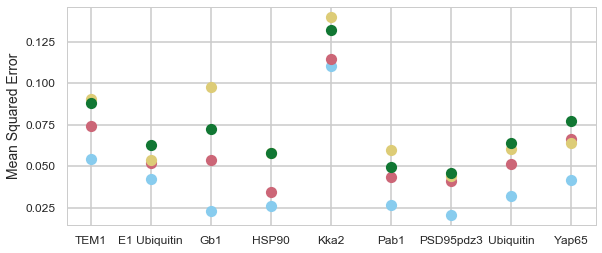

In [24]:
fig = plt.figure(figsize=(4.74*2, 2*2))
ax = fig.subplots()
intermediate.T.plot(marker='o',linewidth=0, ax=ax, legend=None)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(range(9),intermediate.columns, rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=14)
#plt.xticks(range(9),functions, rotation=0)

#plt.title("Mean Squared Error - Function Prediction")

#plot_style_utils.save_for_pub(fig=fig, path="./figures/functional_datasets_names", dpi=250)

(array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ]),
 <a list of 7 Text yticklabel objects>)

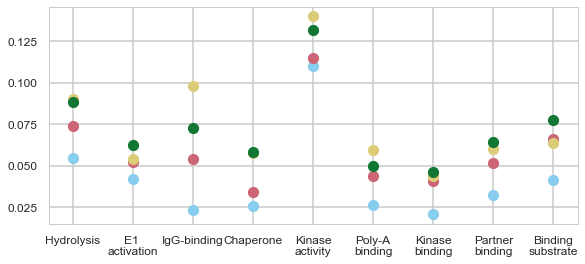

In [25]:
fig = plt.figure(figsize=(4.74*2, 2*2))
ax = fig.subplots()
intermediate.T.plot(marker='o',linewidth=0, ax=ax, legend=None)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xticks(range(9),intermediate.columns, rotation=0, fontsize=12)
plt.xticks(range(9),functions, rotation=0, fontsize=12)
plt.yticks(fontsize=12)

#plt.title("Mean Squared Error - Function Prediction")

#plot_style_utils.save_for_pub(fig=fig, path="./figures/functional_datasets", dpi=250)

# how different are the wildtype sequences?

In [26]:
fowler_seqs = pd.Series({'Kka2': 'MIEQDGLHAGSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSGALNELQDEAARLSWLATTGVPCAAVLDVVTEAGRDWLLLGEVPGQDLLSSHLAPAEKVSIMADAMRRLHTLDPATCPFDHQAKHRIERARTRMEAGLVDQDDLDEEHQGLAPAELFARLKARMPDGEDLVVTHGDACLPNIMVENGRFSGFIDCGRLGVADRYQDIALATRDIAEELGGEWADRFLVLYGIAAPDSQRIAFYRLLDEFF',
 'PSD95pdz3': 'MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLEAPGYELQVNGTEGEMEYEEITLERGNSGLGFSIAGGTDNPHIGDDPSIFITKIIPGGAAAQDGRLRVNDSILFVNEVDVREVTHSAAVEALKEAGSIVRLYVMRRKPPAEKVMEIKLIKGPKGLGFSIAGGVGNQHIPGDNSIYVTKIIEGGAAHKDGRLQIGDKILAVNSVGLEDVMHEDAVAALKNTYDVVYLKVAKPSNAYLSDSYAPPDITTSYSQHLDNEISHSSYLGTDYPTAMTPTSPRRYSPVAKDLLGEEDIPREPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEYSRFEAKIHDLREQLMNSSLGSGTASLRSNPKRGFYIRALFDYDKTKDCGFLSQALSFRFGDVLHVIDAGDEEWWQARRVHSDSETDDIGFIPSKRRVERREWSRLKAKDWGSSSGSQGREDSVLSYETVTQMEVHYARPIIILGPTKDRANDDLLSEFPDKFGSCVPHTTRPKREYEIDGRDYHFVSSREKMEKDIQAHKFIEAGQYNSHLYGTSVQSVREVAEQGKHCILDVSANAVRRLQAAHLHPIAIFIRPRSLENVLEINKRITEEQARKAFDRATKLEQEFTECFSAIVEGDSFEEIYHKVKRVIEDLSGPYIWVPARERL',
 'Pab1': 'MADITDKTAEQLENLNIQDDQKQAATGSESQSVENSSASLYVGDLEPSVSEAHLYDIFSPIGSVSSIRVCRDAITKTSLGYAYVNFNDHEAGRKAIEQLNYTPIKGRLCRIMWSQRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAPHLSRKERDSQLEETKAHYTNLYVKNINSETTDEQFQELFAKFGPIVSASLEKDADGKLKGFGFVNYEKHEDAVKAVEALNDSELNGEKLYVGRAQKKNERMHVLKKQYEAYRLEKMAKYQGVNLFVKNLDDSVDDEKLEEEFAPYGTITSAKVMRTENGKSKGFGFVCFSTPEEATKAITEKNQQIVAGKPLYVAIAQRKDVRRSQLAQQIQARNQMRYQQATAAAAAAAAGMPGQFMPPMFYGVMPPRGVPFNGPNPQQMNPMGGMPKNGMPPQFRNGPVYGVPPQGGFPRNANDNNQFYQQKQRQALGEQLYKKVSAKTSNEEAAGKITGMILDLPPQEVFPLLESDELFEQHYKEASAAYESFKKEQEQQTEQA',
 'TEM-1': 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW',
 'UBI4': 'MQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGMQIFVKTLTGKTITLEVESSDTIDNVKSKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGGN',
 'Yap65': 'MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGDSETDLEALFNAVMNPKTANVPQTVPMRLRKLPDSFFKPPEPKSHSRQASTDAGTAGALTPQHVRAHSSPASLQLGAVSPGTLTPTGVVSGPAATPTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNSNQQQQMRLQQLQMEKERLRLKQQELLRQAMRNINPSTANSPKCQELALRSQLPTLEQDGGTQNPVSSPGMSQELRTMTTNSSDPFLNSGTYHSRDESTDSGLSMSSYSVPRTPDDFLNSVDEMDTGDTINQSTLPSQQNRFPDYLEAIPGTNVDLGTLEGDGMNIEGEELMPSLQEALSSDILNDMESVLAATKLDKESFLTWL',
 'gb1': 'MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTTGEGSNPFFTAAALAVMAGAGALAVASKRKED',
 'hsp90': 'MASETFEFQAEITQLMSLIINTVYSNKEIFLRELISNASDALDKIRYKSLSDPKQLETEPDLFIRITPKPEQKVLEIRDSGIGMTKAELINNLGTIAKSGTKAFMEALSAGADVSMIGQFGVGFYSLFLVADRVQVISKSNDDEQYIWESNAGGSFTVTLDEVNERIGRGTILRLFLKDDQLEYLEEKRIKEVIKRHSEFVAYPIQLVVTKEVEKEVPIPEEEKKDEEKKDEEKKDEDDKKPKLEEVDEEEEKKPKTKKVKEEVQEIEELNKTKPLWTRNPSDITQEEYNAFYKSISNDWEDPLYVKHFSVEGQLEFRAILFIPKRAPFDLFESKKKKNNIKLYVRRVFITDEAEDLIPEWLSFVKGVVDSEDLPLNLSREMLQQNKIMKVIRKNIVKKLIEAFNEIAEDSEQFEKFYSAFSKNIKLGVHEDTQNRAALAKLLRYNSTKSVDELTSLTDYVTRMPEHQKNIYYITGESLKAVEKSPFLDALKAKNFEVLFLTDPIDEYAFTQLKEFEGKTLVDITKDFELEETDEEKAEREKEIKEYEPLTKALKEILGDQVEKVVVSYKLLDAPAAIRTGQFGWSANMERIMKAQALRDSSMSSYMSSKKTFEISPKSPIIKELKKRVDEGGAQDKTVKDLTKLLYETALLTSGFSLDEPTSFASRINRLISLGLNIDEDEETETAPEASTAAPVEEVPADTEMEEVD'})

In [27]:
fowler_seqs.map(len).sort_values()

Kka2         264
TEM-1        286
UBI4         381
gb1          448
Yap65        504
Pab1         577
hsp90        709
PSD95pdz3    724
dtype: int64

In [28]:
import Levenshtein

In [29]:
distances = pd.DataFrame(index = fowler_seqs.index, columns = fowler_seqs.index)
for i in fowler_seqs.index:
    for j in fowler_seqs.index:
        distances.loc[i,j] = Levenshtein.ratio(fowler_seqs.loc[i],fowler_seqs.loc[j])

In [30]:
def mut(st):
    sub_position = np.random.randint(0,len(st))
    return st[:sub_position] + 'A' + st[sub_position+1:]

## 1 mutation away:

In [31]:
fowler_seqs.map(lambda x: np.mean([Levenshtein.ratio(x, mut(x)) for i in range(100)])).mean()

0.99787258081778485

## average similarity between 8 proteins in this analysis:

In [32]:
distances.mean().mean()

0.42680292510101953

# How much better are we at quantitative function prediction?

In [33]:
print(intermediate.loc['Best Doc2Vec'] / intermediate.loc['UniRep Fusion'])
print('mean',(intermediate.loc['Best Doc2Vec'] / intermediate.loc['UniRep Fusion']).mean())

TEM1            1.61655
E1 Ubiquitin    1.48562
Gb1             3.11211
HSP90           2.24872
Kka2            1.19785
Pab1            1.86475
PSD95pdz3       2.21245
Ubiquitin       1.97969
Yap65            1.8598
dtype: object
mean 1.95306000874


# The non Quantitative function prediction parts of Supp. Table S4-S5:

## Small scale function prediction tasks from Yang 2018

In [34]:
intermediate = final_table.loc[:,['arnold_T50', 'arnold_absorption', 'arnold_enantioselectivity',
       'arnold_localization']].copy()
intermediate.index = [plot_style_utils.main_text_rep_names[n] for n in intermediate.index]

intermediate.columns = [task_names[n] for n in intermediate.columns.levels[0][intermediate.columns.labels[0]]]

#intermediate.columns = [f"plot_style_utils." d,s in intermediate.columns]

intermediate.style.apply(
    highlight_min, axis=0
).set_precision(3).set_table_styles(
        [
            dict(selector="th",props=[('max-width', '120px'), ('text-align','center')]),
            dict(selector="td",props=[('text-align','center')])
        ]
    )

,Cytochrome P450 Thermostability,Rhodopsin Peak Absorption Wavelength,Epoxide Hydrolase Enantioselectivity,Channelrhodopsin Membrane Localization
UniRep Fusion,15.8,499,189,1.25
Our Best Baseline,21.7,571,93.2,0.912
RGN,24.4,2.79e+03,1.2e+03,1.61
Best Doc2Vec,18.1,530,95.7,1


## Stability tasks

In [35]:
intermediate = final_table.loc[:,['rocklin_ssm2','rocklin_all_rds']].copy()

intermediate.index = [plot_style_utils.main_text_rep_names[n] for n in intermediate.index]

intermediate.columns = [task_names[n] for n in intermediate.columns.levels[0][intermediate.columns.labels[0]]]

#.style.apply(highlight_min, axis=0).set_precision(3)
intermediate.style.apply(highlight_min, axis=0).set_precision(3).set_table_styles(
        [
            dict(selector="th",props=[('max-width', '120px'), ('text-align','center')]),
            dict(selector="td",props=[('text-align','center')])
        ]
    )

,Natural & De-Novo Designed Proteins Stability - Site Saturation Mutagenesis,De-Novo Designed Proteins Stability - Design Rounds
UniRep Fusion,0.0304,0.179
Our Best Baseline,0.0398,0.201
RGN,0.0338,0.189
Best Doc2Vec,0.0473,0.258


## how much better?

In [36]:
display(intermediate.loc['Best Doc2Vec'] / intermediate.loc['UniRep Fusion'])
print('mean',(intermediate.loc['Best Doc2Vec'] / intermediate.loc['UniRep Fusion']).mean())

Natural & De-Novo Designed Proteins Stability - Site Saturation Mutagenesis    1.55695
De-Novo Designed Proteins Stability - Design Rounds                            1.43851
dtype: object

mean 1.49772700136


In [37]:
# Holds in separate analysis for natural and engineered proteins too!

intermediate = final_table.loc[:,['rocklin_ssm2_nat_eng']].copy()

intermediate.index = [plot_style_utils.main_text_rep_names[n] for n in intermediate.index]

intermediate.columns = [task_names[n] for n in intermediate.columns.levels[1][intermediate.columns.labels[1]]]

#.style.apply(highlight_min, axis=0).set_precision(3)
intermediate.style.apply(highlight_min, axis=0).set_precision(3).set_table_styles(
        [
            dict(selector="th",props=[('max-width', '120px'), ('text-align','center')]),
            dict(selector="td",props=[('text-align','center')])
        ]
    )

,Natural,De-Novo Designed
UniRep Fusion,0.0342,0.0255
Our Best Baseline,0.0532,0.0322
RGN,0.0449,0.0277
Best Doc2Vec,0.0711,0.0388
